# Computer Vision Classification Exercise
The dataset examined comes from PyTorch (https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html).
It contains a collection of 28x28 pixel images of handwritten digits labeled with the corresponding digit.

The goal of this exercise is a Convolutional Neuronal Network classification model that predicts for an given image the handwritten digit on it.

In [1]:
import os
import sys
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

First, we define a few classes. One for simultaneous logging and output of the training. And the CNN for predicting the handwritten digit.

The first layer is a convolution layer that takes an input of 1x28x28 and converts it to 32x28x28. Why 32? Because this provides sufficient capacity for recognizing patterns/features such as curves and edges. This is followed by normalization for stabilization, which means that the subsequent ReLu function 'cuts off' less information and the training becomes more stable. The ReLu function removes negative values and ensures non-linearity. The second convolution layer is used to learn the pattern combination. Then normalization and Relu again. The following MaxPooling reduces the height and width from 28x28 to 14x14. This reduces the parameters and ensures greater robustness with regard to shifts, noise, and different writing styles.

Next comes another convolutional layer, which takes 32x14x14 and outputs 64x14x14. This layer should recognize abstract features such as pixel clusters and parts of digits. Normalization and ReLu for the reasons already mentioned. This is followed by our last convolutional layer for feature combinations. This layer does not change the size. After normalization and ReLu, we use MaxPool again to change the size from 64x14x14 to 64x7x7.

Then we randomly dropout 30% of all neurons to prevent overfitting. In effect, we force the model to learn more robust features. We use a linear transformation to compress the 64x7x7=3136 features to 128. Again, we use a ReLU function and, after another 30% dropout, we transform linearly into the 10 different classes.

In [2]:
class JupyterDualLogger:
    def __init__(self, logfile="model/training.log"):
        self.log = open(logfile, "a", encoding="utf-8")
        self.stdout = sys.stdout  # Jupyter's output stream

    def write(self, message):
        self.stdout.write(message)
        self.log.write(message)

    def flush(self):
        self.stdout.flush()
        self.log.flush()

    
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 28 → 14
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 14 → 7
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Second, we define some functions that will be used to train the model. We only train if no model has been trained and saved yet. If there is no model at the desired storage location, training begins. At each training iteration/epoch, we evaluate the model using the evaluation data and save it. If an iteration occurs that has a higher evaluation loss than a previous iteration, the model is not saved. This means that after training, we have the best model in terms of the evaluation data. If three iterations occur with a higher evaluation loss than before, we stop training. We document everything in history, which is also saved.

In [3]:
def save_checkpoint(model, optimizer, history, path="model/mnist_cnn.pth"):
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history
    }
    torch.save(checkpoint, path)
    print(f"Model saves at: {path}")


def load_checkpoint(model, optimizer=None, path="model/mnist_cnn.pth"):
    if not os.path.exists(path):
        return None

    checkpoint = torch.load(path, map_location="cpu")
    model.load_state_dict(checkpoint["model_state"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state"])

    print(f"Model loaded from: {path}")
    return checkpoint["history"]


def train_model(model, train_loader, val_loader, optimizer, criterion, 
                epochs=10, patience=3, device="cpu"):

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_loss = float("inf")
    wait = 0

    model.to(device)

    for epoch in range(1, epochs + 1):
        print(f"\n=== Epoch {epoch}/{epochs} ===")

        # ---------- Training ----------
        model.train()
        train_loss_sum, total, correct = 0, 0, 0

        for X, y in tqdm(train_loader, desc="Training", leave=False):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * X.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = train_loss_sum / total
        train_acc = correct / total

        # ---------- Validation ----------
        model.eval()
        val_loss_sum, total, correct = 0, 0, 0

        with torch.no_grad():
            for X, y in tqdm(val_loader, desc="Validation", leave=False):
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)

                val_loss_sum += loss.item() * X.size(0)
                preds = out.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss = val_loss_sum / total
        val_acc = correct / total

        # ---------- History ----------
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ---------- Early Stopping ----------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), "model/best_model_temp.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early Stopping triggered")
                break

    model.load_state_dict(torch.load("model/best_model_temp.pth"))
    os.remove("model/best_model_temp.pth")

    return history


def train_or_load(model, train_loader, val_loader, optimizer, criterion,
                  model_path="model/mnist_cnn.pth", device="cpu"):

    history = load_checkpoint(model, optimizer, model_path)

    if history is not None:
        print("Loading model, no training necessary.")
        return history

    print("No model found, start training...")

    sys.stdout = JupyterDualLogger("model/training.log")

    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=10,
        patience=3,
        device=device
    )

    sys.stdout = sys.__stdout__

    save_checkpoint(model, optimizer, history, model_path)

    return history

Next, we download the data and transform it. Data augmentation of the training data is important because it allows us to obtain variations in the data, such as shifts, rotations, scalings, and deformations of the images.

In [ ]:
torch.manual_seed(42)

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 64

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=train_transform)
test_dataset  = datasets.MNIST(root="data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Finally, we define the loss function. This is a cross-entropy, so we don't have to worry about the balance of the training set. The Adam algorithm is used as the optimizer. SGD also works, but I prefer Adam because it uses different learning rates for each parameter. This usually leads to faster 'convergence'.
Now we start training or load the already trained model.

In [5]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

history = train_or_load(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    model_path="model/mnist_cnn.pth",
    device=device
)

No model found, start training...

=== Epoch 1/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2642, Train Acc: 0.9170 | Val Loss: 0.0551, Val Acc: 0.9817

=== Epoch 2/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1129, Train Acc: 0.9655 | Val Loss: 0.0407, Val Acc: 0.9867

=== Epoch 3/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0929, Train Acc: 0.9725 | Val Loss: 0.0282, Val Acc: 0.9910

=== Epoch 4/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0848, Train Acc: 0.9751 | Val Loss: 0.0263, Val Acc: 0.9927

=== Epoch 5/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0735, Train Acc: 0.9784 | Val Loss: 0.0203, Val Acc: 0.9931

=== Epoch 6/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0692, Train Acc: 0.9792 | Val Loss: 0.0228, Val Acc: 0.9923

=== Epoch 7/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0584, Train Acc: 0.9827 | Val Loss: 0.0244, Val Acc: 0.9933

=== Epoch 8/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0603, Train Acc: 0.9822 | Val Loss: 0.0187, Val Acc: 0.9938

=== Epoch 9/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0555, Train Acc: 0.9838 | Val Loss: 0.0211, Val Acc: 0.9930

=== Epoch 10/10 ===


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.0523, Train Acc: 0.9850 | Val Loss: 0.0136, Val Acc: 0.9951


Finally, we use the history to create some plots. First, a plot for loss and accuracy. Second, a confusion matrix to visualize the model's prediction.

In [6]:
def plot_history(history):
    epochs = range(1, len(history["val_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # LOSS
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Evaluation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ACCURACY
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Evaluation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

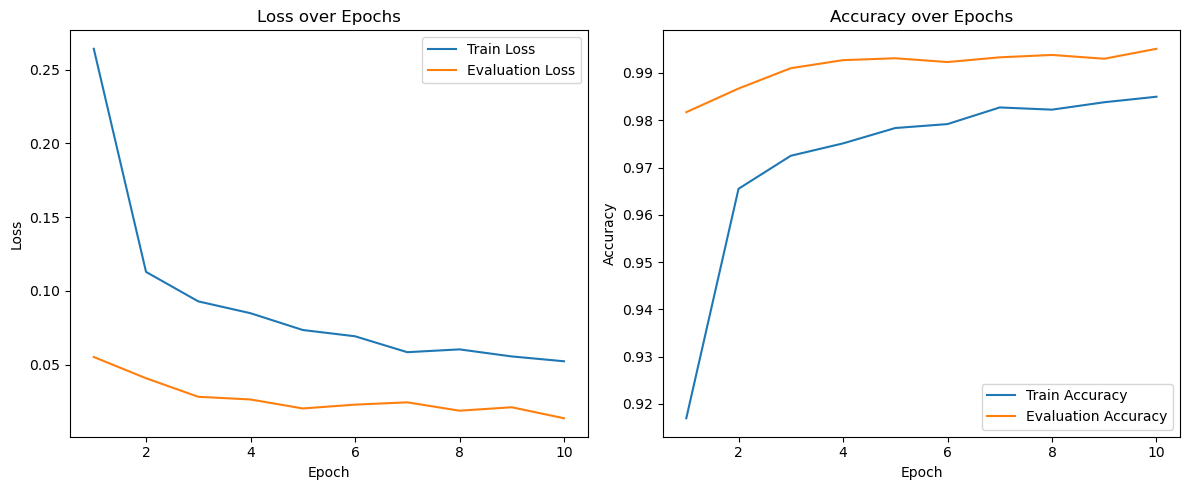

In [7]:
plot_history(history)

The model has more problems with the training data than with the evaluation data. This is due to data augmentation, as the training data is noisy, rotated, and shifted. The evaluation data is not.

In [8]:
def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            preds = out.argmax(1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    return torch.cat(all_preds), torch.cat(all_labels)


def plot_confusion_matrix(model, loader):
    preds, labels = get_all_preds(model, loader)

    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

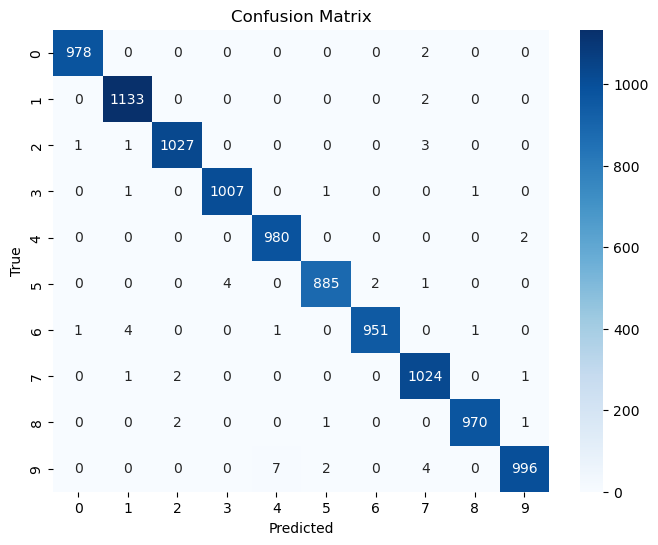

In [9]:
plot_confusion_matrix(model, test_loader)